In [ ]:
import pandas as pd
import os
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
#from torchvision.transforms import transforms

from lib.cfg import *
from lib.dataloader import get_calcification_data_index, DatasetThyroid
from lib.model import Net_v2

In [2]:
# Dataloader init
df_data_index = get_calcification_data_index()

df_label_all = pd.read_csv(BASE_PATH + 'malignancy_label/thyroid_all.csv')
df_label_test = pd.read_csv(BASE_PATH + 'malignancy_label/thyroid_test198.csv')
id_all = list(map(lambda x: int(re.findall(r'\d+', x)[0]), df_label_all['id']))
id_test = list(map(lambda x: int(re.findall(r'\d+', x)[0]), df_label_test['id']))
id_train = list(set(id_all) - set(id_test))
df_label_all['id'] = id_all

print('Data train size: ', len(id_train))
print('Data test size: ', len(id_test))
df_data_index_train = pd.DataFrame({'id': id_train}).merge(df_data_index).merge(df_label_all)
df_data_index_test = pd.DataFrame({'id': id_test}).merge(df_data_index).merge(df_label_all)

# ~3G RAM per image
batch_size_train = 2
dataloader_train = DataLoader(
    DatasetThyroid(df_data_index_train, image_transform, mask_transform, True), 
    batch_size=batch_size_train,  
    shuffle=True,
    num_workers=1
)

batch_size_test = 4
dataloader_test = DataLoader(
    DatasetThyroid(df_data_index_test, image_transform, mask_transform, False), 
    batch_size=batch_size_test,
    shuffle=False,
    num_workers=1
)

Data train size:  2794
Data test size:  198


In [4]:
# Multi-task
unet = Net_v2(3, 2).cuda()
unet.load_state_dict(torch.load('./unet_aux_leaky_epoch40.pth'))

optimizer = optim.Adam(unet.parameters(), lr=1e-3)
class_weights = torch.tensor([1.7]).cuda()
criterion = nn.BCEWithLogitsLoss()
criterion_malignant = nn.BCELoss(weight=class_weights)

In [ ]:
# Train
epoch_start = 0
num_epochs = 40
step_count_train = len(dataloader_train.dataset)/batch_size_train
step_count_test = len(dataloader_test.dataset)/batch_size_test

for epoch in range(epoch_start, epoch_start+num_epochs):
    print('Epoch {}/{}'.format(epoch, epoch_start+num_epochs - 1))
    print('-' * 10)

    # Train loss
    train_loss = 0
    train_loss_temp = 0
    train_step = 0
    for img, lesion_mask, calci_mask, img_id, cal_mask_exist, malignant in tqdm(dataloader_train, total=step_count_train):
        train_step += 1
        
        img = img.cuda()
        lesion_mask = lesion_mask.cuda()
        calci_mask = calci_mask.cuda()
        malignant = malignant.float().cuda()

        optimizer.zero_grad()

        seg, malignant_pred = unet(img)
        lesion_mask_pred = seg[:, 0].unsqueeze(1)
        calci_mask_pred = seg[:, 1].unsqueeze(1)
        malignant_pred = malignant_pred.squeeze()

        lesion_loss = criterion(lesion_mask_pred, lesion_mask)
        calci_loss = criterion(calci_mask_pred[cal_mask_exist], calci_mask[cal_mask_exist])
        malignant_loss = criterion_malignant(malignant_pred, malignant)
        
        if calci_loss.isnan():
            calci_loss = torch.tensor(0)
        loss = lesion_loss + calci_loss*5 + malignant_loss*0.25

        loss.backward()
        optimizer.step()
        
        loss_temp = lesion_loss + calci_loss
        train_loss_temp += loss_temp.item()

        train_loss += loss.item()
    train_loss_avg = train_loss/train_step
    print("Epoch %d | Train Loss: %0.3f" % (epoch, train_loss_avg))
    print("Epoch %d | Train Loss exclude maligancy: %0.3f" % (epoch, train_loss_temp/train_step))
    
    # Test loss
    test_loss = 0
    test_step = 0
    for img, lesion_mask, calci_mask, img_id, cal_mask_exist, malignant in tqdm(dataloader_test, total=step_count_test):
        test_step += 1
        with torch.no_grad():
            img = img.cuda()
            lesion_mask = lesion_mask.cuda()
            calci_mask = calci_mask.cuda()
            malignant = malignant.float().cuda()
            
            seg, malignant_pred = unet(img)
            lesion_mask_pred = seg[:, 0].unsqueeze(1)
            calci_mask_pred = seg[:, 1].unsqueeze(1)
            malignant_pred = malignant_pred.squeeze()
        
            lesion_loss = criterion(lesion_mask_pred, lesion_mask)
            calci_loss = criterion(calci_mask_pred[cal_mask_exist], calci_mask[cal_mask_exist])
            malignant_loss = criterion_malignant(malignant_pred, malignant)
            
            if calci_loss.isnan():
                calci_loss = torch.tensor(0)
            loss = lesion_loss + calci_loss #+ malignant_loss
            
            test_loss += loss.item()
    test_loss_avg = test_loss/test_step
    print("Epoch %d | Test Loss: %0.3f" % (epoch, test_loss_avg))


In [5]:
df_data_index_test = pd.DataFrame({'id': [2271, 115, 160, 161]}).merge(df_data_index).merge(df_label_all)
batch_size_test = 4
dataloader_test = DataLoader(
    DatasetThyroid(df_data_index_test, image_transform, mask_transform, False), 
    batch_size=batch_size_test,
    shuffle=False,
    num_workers=1
)

In [6]:
from matplotlib import pyplot as plt

img, lesion_mask, calci_mask, img_id, cal_mask_exist, malignant = next(iter(dataloader_test)) 

img = img.cuda()
lesion_mask = lesion_mask.cuda()
calci_mask = calci_mask.cuda()
malignant = malignant.float().cuda()

optimizer.zero_grad()

seg, malignant_pred = unet(img)
lesion_mask_pred = seg[:, 0].unsqueeze(1)
calci_mask_pred = seg[:, 1].unsqueeze(1)
malignant_pred = malignant_pred.squeeze()

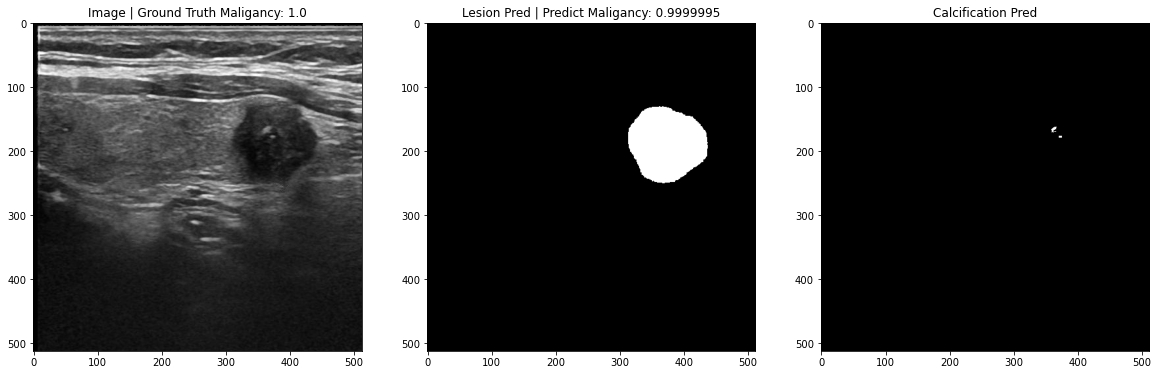

In [7]:
i = 0
malignant_str = str(malignant[i].cpu().numpy())
malignant_pred_str = str(malignant_pred[i].detach().cpu().numpy())

# Image + Lesion GT
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(131)
ax.set_title('Image | Ground Truth Maligancy: ' + malignant_str)
plt.imshow(img[i,0].detach().cpu(), cmap='gray')

ax = fig.add_subplot(132)
ax.set_title('Lesion Pred | Predict Maligancy: ' + malignant_pred_str)
plt.imshow(lesion_mask_pred[i,0].detach().cpu() > 0, cmap='gray')

ax = fig.add_subplot(133)
ax.set_title('Calcification Pred')
plt.imshow(calci_mask_pred[i,0].detach().cpu() > 0, cmap='gray')